# Neural Nets for jet images

Notebook for training and evaluating neural network taggers using jet images.

This example is about separating jets (collimated sprays of hadronic particles) using an "imaging" technique based on a convolutional neural network. SignaL jets are from hadronic decays of W bosons, while background jets are produced from the hadronisation of light quarks, or gluons. The jets are measured in the detector calorimeter, where they leave their energy. The images are the trnasverse energies deposited by a jet in the calorimeter cells, with each image being centred on the jet axis, and the weight of each cell is the transverse energy deposited. Jets from background tend to have most of the transverse enrgy deposited in the centre, while those from BG, that are actually composed of two very nearby jets, present rather a two-prong structure, and the network should be able to distinguish the two cases.
Write a concolutional neural network to distinguish the teo classes, train it, and evaluate its performance.


---

---

# **Jets Project - Final Merged Data Optimisation Notebook** 
*Student Number: 20006434* 

***Project Description:***
As explained in the project brief above, this project concerns the classification of jet images through use of a convolutional neural network. A model will be created, optimised and evaluated; with all results, decisions and conclusions written up in the report.

***This Notebook:***
As explained in the report, this notebook corresponds to the investigations using the images of all 4 datasets merged into one set to be used for training, such that the model can generalise better than when trained on each set sequentially!

## Notebook Setup
We will start by setting up the notebook for coding, by importing libraries and connecting the notebook to our google drive, such that files can be loaded and downloaded.

In [ ]:
# Importing the necessary libraries

from __future__ import division, print_function
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.regularizers import l1_l2
#from keras.callbacks import EarlyStopping
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score
from datetime import datetime
import os, sys
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib

In [ ]:
# Loading my drive to google colab, for the uploading/downloading of files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Data
We will now define a function to import the datasets, as well as manipulate/merge a certain amount of the images from each set together. We will then check that the images have been imported, by loading a random image from both signal and background categories, as well as the overall sum of both, to see any overarching patterns.

In [ ]:
# Defining the paths to the necessary jet image datasets
inputs = ["/content/drive/MyDrive/Colab Notebooks/Project/20190920_partial_10k/20190920_pt300.0_600.0_40bins_10k.npz", 
          "/content/drive/MyDrive/Colab Notebooks/Project/20190920_partial_10k/20190920_pt600.0_1500.0_40bins_10k.npz", 
          "/content/drive/MyDrive/Colab Notebooks/Project/20190920_partial_10k/20190920_pt1500.0_2500.0_40bins_10k.npz",
          "/content/drive/MyDrive/Colab Notebooks/Project/20190920_partial_10k/20190920_pt2500.0_5000.0_40bins_10k.npz"]

# Defining how many of each 4 .npz file sets' images to keep (Out of 10000)
nb_top_lund_planes = 10000
nb_QCD_lund_planes = 10000
nb_W_lund_planes =   10000

# Defining the split of training/validation data
test_sample_size = 0.25

In [ ]:
# Defining a function to import/manipulate our image data
def import_data(files, n):
  ''' This function is used to import data, and seperate it into training and testing datasets.
  It takes inputs of:
    files - A list containing the paths to all .npz files
    n     - A string which will be used to determine whether the 'top' or 'w' jets are used as signals
  It outputs:
    X_train and y_train  - Signal + BG Training images and labels
    X_test and y_test    - Signal + BG Testing images and labels 
  '''

  # Setting up empty lists for appending a fraction of each image set to
  Total_top=[]
  Total_w=[]
  Total_qcd=[]

  # Looping to append images from each .npz file
  for i in files:

    # Load the data
    input_data = np.load(i)

    # Keep only some of the images
    top_samples=input_data['top_jet_images'][:nb_top_lund_planes]    # signal
    w_samples=input_data['W_jet_images'][:nb_W_lund_planes]          # signal
    qcd_samples=input_data['QCD_jet_images'][:nb_QCD_lund_planes]    # background gluon and quark
    
    # Append them to the empty lists
    Total_top += top_samples.tolist()
    Total_w += w_samples.tolist()
    Total_qcd += qcd_samples.tolist()
  
  # Converting lists to arrays for simpler operations
  Total_top = np.array(Total_top)
  Total_w = np.array(Total_w)
  Total_qcd = np.array(Total_qcd)
  
  # Identifying which signal to use
  if n=='top':
    X_S = Total_top   # Use signals from top quark jets
  elif n=='w':
    X_S = Total_w     # Use signals from w boson decay jets
  else:
    raise Exception("Please pick either 'top' or 'w' samples")
  
  # Identify the background jets and shuffle, as background should be unrelated to signal order/images
  X_BG = Total_qcd 
  np.random.shuffle(X_BG)

  # Create labels
  y_S = np.ones(len(X_S))
  y_BG = np.zeros(len(X_BG)) 

  # Make image and label arrays
  X = np.append(X_S, X_BG, axis=0)
  y = np.append(y_S, y_BG, axis=0)

  # CNN architecture is built to take color images. 
  # Therefore, reshape input to: 1 colour channel + 1 image channel
  X = X.reshape( (X.shape[0], X.shape[1], X.shape[2], 1) )

  # Split data into training and testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sample_size)

  # Reshaping labels 
  y_train=np.reshape(y_train,(len(y_train),1))
  y_test=np.reshape(y_test,(len(y_test),1))

  return X_train, X_test, y_train, y_test, X_S, X_BG

In [ ]:
# Running the function to import the images, setting w->qq jets as the signal
X_train, X_test, y_train, y_test, X_S, X_BG = import_data(inputs, 'w')

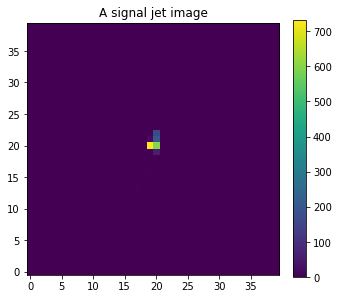

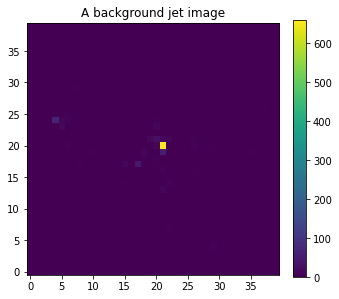

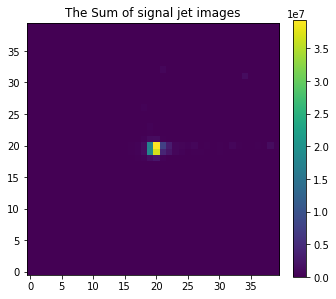

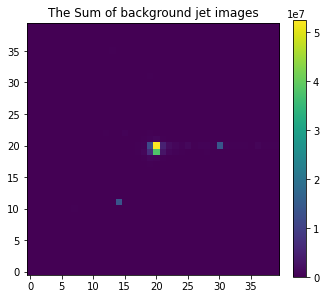

In [ ]:
# Picking a random image index to show
iimg_sig = np.random.randint(0,len(X_S))
iimg_bkg = np.random.randint(0,len(X_BG))

# Plotting a random signal jet image
plt.figure(figsize=(5,5))
plt.title("A signal jet image", fontsize=12)
plt.imshow(X_S[iimg_sig].reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
plt.colorbar(fraction=0.046);

# Plotting a random background jet image
plt.figure(figsize=(5,5))
plt.title("A background jet image", fontsize=12)
plt.imshow(X_BG[iimg_bkg].reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
plt.colorbar(fraction=0.046);

# Plotting the sum of all signal jet images
plt.figure(figsize=(5,5))
plt.title("The Sum of signal jet images", fontsize=12)
plt.imshow(np.sum(X_S, axis=0).reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
plt.colorbar(fraction=0.046);

# Plotting the sum of all background jet images
plt.figure(figsize=(5,5))
plt.title("The Sum of background jet images", fontsize=12)
plt.imshow(np.sum(X_BG, axis=0).reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
plt.colorbar(fraction=0.046);

## Model Training
We will now define, compile and train the model, on the image/label data produced above.

In [ ]:
# Defining the sequential CNN model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(160, (3, 3), activation='relu', input_shape=(40, 40, 1)))
model.add(keras.layers.Conv2D(160, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(160, (3, 3), activation='relu'))
model.add(keras.layers.Dropout(rate=.3))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dropout(rate=.3))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(2, activation='sigmoid'))

# Printing a model summary
model.summary()

# Unused/Removed features
  # es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
  # kernel_regularizer=l1_l2())) with defaults 0.01 both

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 160)       1600      
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 160)       230560    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 160)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 160)       230560    
                                                                 
 dropout (Dropout)           (None, 16, 16, 160)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 160)        0         
 2D)                                                    

In [ ]:
# Defining compilation possiblities
optimizer = tf.keras.optimizers.RMSprop()  #'adam
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #'categorical_crossentropy' #'mean_squared_error'
metrics = ['accuracy'] #['SparseCategoricalAccuracy']

# Compiling the model
model.compile(optimizer=optimizer,loss=loss_function, metrics=metrics)

# Defining useful training settings
nb_epochs = 20
batch_size = 128

In [ ]:
# Training the model, and outputting the training history
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size, validation_data=(X_test, y_test)) #callbacks=[es])

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 42s 73ms/step - loss: 2.0675 - accuracy: 0.5353 - val_loss: 0.7552 - val_accuracy: 0.5735
Epoch 2/20
469/469 [==============================] - 33s 71ms/step - loss: 1.1763 - accuracy: 0.6300 - val_loss: 0.6538 - val_accuracy: 0.6981
Epoch 3/20
469/469 [==============================] - 34s 72ms/step - loss: 0.7451 - accuracy: 0.6874 - val_loss: 0.6019 - val_accuracy: 0.6984
Epoch 4/20
469/469 [==============================] - 34s 72ms/step - loss: 0.6535 - accuracy: 0.7172 - val_loss: 0.5599 - val_accuracy: 0.7258
Epoch 5/20
469/469 [==============================] - 34s 72ms/step - loss: 0.5720 - accuracy: 0.7327 - val_loss: 0.5476 - val_accuracy: 0.7379
Epoch 6/20
469/469 [==============================] - 34s 73ms/step - loss: 0.5646 - accuracy: 0.7432 - val_loss: 0.5392 - val_accuracy: 0.7374
Epoch 7/20
469/469 [==============================] - 37s 79ms/step - loss: 0.5504 - accuracy: 0.7482 - val_loss: 0.5131 - val_accuracy: 0.7560
Epo

In [ ]:
# Code to save and load models
  #model.save('my_final_merged_model.h5')
  #model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Project/model data/my_final_merged_model.h5')
  #model.summary()

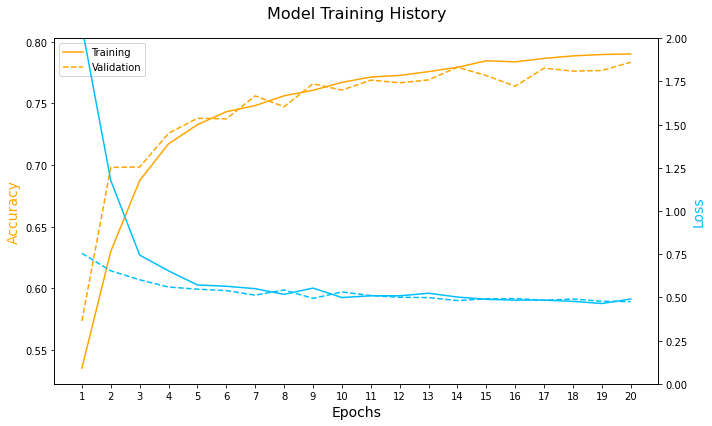

In [ ]:
# Defining a figure to plot the history information
fig, ax1 = plt.subplots(figsize=(10,6))

# Creating data for the x-axis, to show progression over epochs
x=np.arange(1,nb_epochs+1,1)

# Plotting the training and testing accuracy on one axis
ax1.set_xlabel('Epochs',fontsize=14)
ax1.set_ylabel('Accuracy', color='orange',fontsize=14)
ax1.plot(x, history.history['accuracy'], label='Training', color='orange')
ax1.plot(x, history.history['val_accuracy'], label='Validation', color='orange',linestyle='--')

# Plotting the training and testing loss on another axis (that shares same x)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='deepskyblue',fontsize=14)
ax2.plot(x, history.history['loss'], label='Training', color='deepskyblue')
ax2.plot(x, history.history['val_loss'], label='Validation', color='deepskyblue',linestyle='--')
ax2.set_ylim(0,2) # Adjusting scales so loss is visible

# Extra plot formatting
fig.suptitle('Model Training History',fontsize=16)
ax1.legend()
fig.tight_layout()
plt.xticks(x)
plt.savefig('Merged set 10k final merge 2 nb_20 128.png',dpi=300, facecolor='w')

## Evaluation
We will now evaluate the model by different metrics, including an initial look at the model's general accuracy, as well as its precision/recall abilities and its binary classification performance at different classification thresholds.

### *Accuracy*
The accuracy of a model is simply the fraction of correct classifications made, and is calculated as the number of correct classifications divided by the total number.

In [ ]:
# Evaluating the model's accuracy against all testing images/labels
print("The model's accuracy over all testing images is:")
model.evaluate(X_test,y_test)

# Evaluating the model's accuracy against each .npz files images/labels
print("With accuracies on each individual image set, in order of increasing energy, of:")
for i in inputs:
  X_tr, X_te, y_tr, y_te, X_S, X_BG = import_data([i], 'w')
  model.evaluate(X_te,y_te,batch_size=20)

The model's accuracy over all testing images is:
625/625 [==============================] - 4s 6ms/step - loss: 0.4753 - accuracy: 0.7833
With accuracies on each individual image set, in order of increasing energy, of:
250/250 [==============================] - 2s 7ms/step - loss: 0.4313 - accuracy: 0.8096


The accuracies above show that the model has learnt to generalise effectively to the different sets of jets images, as it performs successfully when tested on them together, and individually. In fact, the model performs better on each individual data set than their combination, indicating that the jets at different energies may share similar features, such that a model trained across the full range is better suited to picking out the subtle signal jet features.

Furthermore, the accuracies above show that the third energy range has the most easily distinguishable signal jets, as the accuracy is the highest. Therefore, if this model were to be used to classify jets for an experiment, use of this energy range could be suggested for the best results! 

### *F1 Score*
The F1 Score is a metric for evaluating a model's accuracy, by combining its precision and recall abilities. The recall of a model is defined as the total number of true positives, out of the total of relevant classifications (true positive + false negatives). This differs from the precision of a model, which is defined as the number of true positives out of all positive classifications.

In other words, the recall quantifies the number of positive classifications made out of all positive examples (How accurate the model is when predicting positive results), whereas the precision quantifies the number of positive classifications that actually belong to the positive class (How well the model identifies all positive results) .

To evaluate the F1 Score, the model must first make predictions, given only input images. 

In [ ]:
# Making predictions of signal/background
yhat = model.predict(X_test, verbose=0)   # Two columns, prob of being SG and BG
classes_x=np.argmax(yhat,axis=1)          # Taking highest prob frome each column

In [ ]:
# Calculating the precision, recall and F1 Score
print(f"The model's precision is {precision_score(y_test,classes_x)}, with a recall of {recall_score(y_test,classes_x)}.")
print(f"These combine to give the model an F1 Score of {f1_score(y_test,classes_x)}")

The model's precision is 0.7787437725896259, with a recall of 0.7940239043824702.
These combine to give the model an F1 Score of 0.7863096118755241


The precision score indicates that when the model predicts a specific jet type, it is correct 78% of the time. The recall of  0.79 suggests that out of all the jets, 79% were correctly identified, and 21% were misidentified. Overall, these scores combine to make the F1 Score, which indicates a reasonably good model.

### *ROC AUC*
The Receiver Operator Characteristic (ROC) curve is a method of evaluation for the binary classification performance of a model. It is a probability curve, showing the probabilities for a model to distinguish between the two classes, at different thresholds. Here, threshold refers to different true positive/false positive rates (TPR/FPR), which represent the two axes.

The AUROC is the Area Under this ROC curve, which quantitatively describes/summarises how well the model distinguishes between the two classes. An AUROC of 1 correctly predicts signals as signal every time, whereas an AUROC of 0 would predict signals as backgrounds every time. Therefore, an AUROC of 0.5 (corresponding to a y=x ROC) is the baseline, as this could be acheived by random guessing.

The area under the ROC curve for this model is 0.8263192011072178.


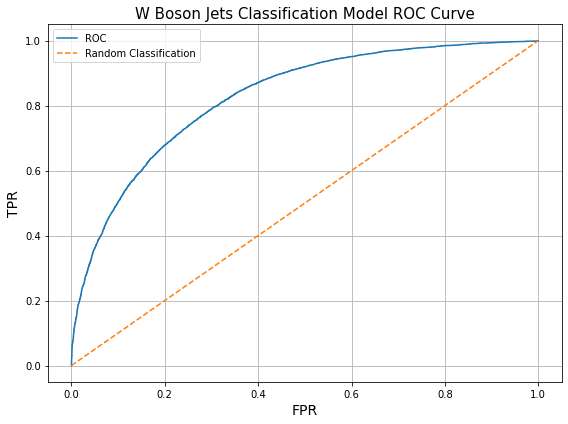

In [ ]:
# Obtaining the FPRs and TPRs
fpr, tpr, thresholds = roc_curve(y_test, yhat[:,1])

# Defining a figure, and plotting the ROC (with baseline)
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(fpr,tpr,label='ROC')
ax1.plot((0,1),(0,1),linestyle='--',label='Random Classification')

# Formatting the figure
ax1.set_title('W Boson Jets Classification Model ROC Curve', fontsize=15)
ax1.set_xlabel('FPR',fontsize=14)
ax1.set_ylabel('TPR',fontsize=14)
ax1.legend()
ax1.grid()
fig.tight_layout()

# Calculating the AUC
auc = roc_auc_score(y_test, yhat[:,1])
print(f"The area under the ROC curve for this model is {auc}.")
plt.savefig('ROC Curve.png',dpi=300, facecolor='w')

The closer to the ROC curve to the top left, the stronger the model's classification performance across more FPR/TPR thresholds. This ROC curve shows excellent distinction capabilities, as evidenced further by the high AUROC value of 0.83.

### *Further Visualisation*
In addition to pure statistics, it would also be helpful to see the classifications made, to see how the probabilities of signal/background jets compare. For example, when signal images were shown, were the probabilities of the jets being signals high, or just higher than the  background probabilities?

For this reason, I will now produce histograms showing the classification probabilities for true signal/background images. I will also plot the difference between the classification probabilities, to see the spread of this seperation.

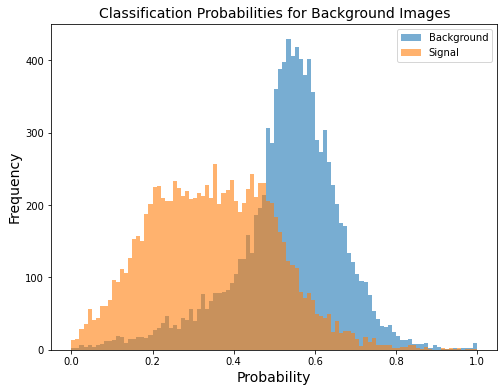

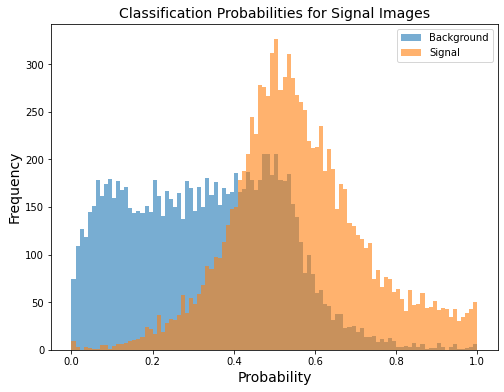

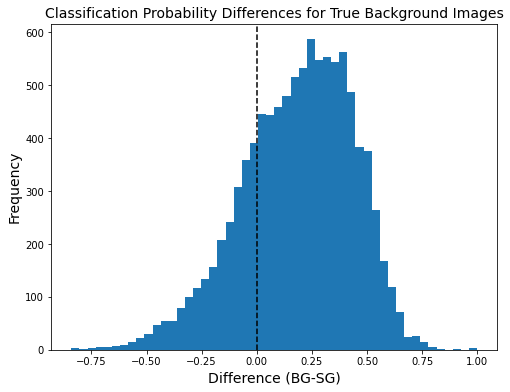

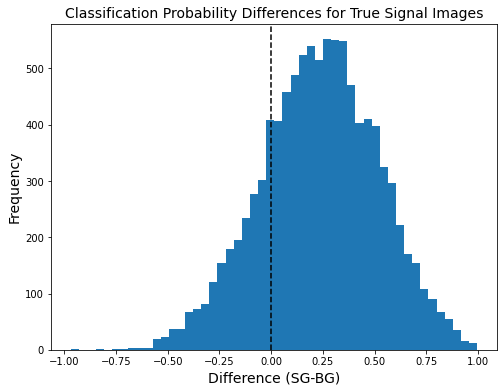

In [ ]:
# Defining empty lists for later appending
trueback_bg_probs=[]      # BG probs for true BG jets
trueback_sg_probs=[]      # SG probs for true BG jets
truesig_bg_probs=[]       # BG probs for true SG jets
truesig_sg_probs=[]       # SG probs for true SG jets

# Looping for each test image/label
for i in range(len(y_test)):

  if int(y_test[i])==0:                  # If a true background image, append probabilities
    trueback_bg_probs.append(yhat[i,0])
    trueback_sg_probs.append(yhat[i,1])
  else:                                  # Else, so if a true signal image, append probabilities
    truesig_bg_probs.append(yhat[i,0])
    truesig_sg_probs.append(yhat[i,1])

# Plotting the probabilities for background jet images
plt.figure(figsize=(8,6))
plt.title('Classification Probabilities for Background Images', fontsize=14)
plt.hist(trueback_bg_probs,bins=100,alpha=0.6,label='Background')
plt.hist(trueback_sg_probs,bins=100,alpha=0.6,label='Signal')
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='best')
plt.savefig('Hist 1 BG.png',dpi=300, facecolor='w');

# Plotting the probabilities for signal jet images
plt.figure(figsize=(8,6))
plt.title('Classification Probabilities for Signal Images', fontsize=14)
plt.hist(truesig_bg_probs,bins=100,alpha=0.6,label='Background')
plt.hist(truesig_sg_probs,bins=100,alpha=0.6,label='Signal')
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='best')
plt.savefig('Hist 1 Sig.png',dpi=300, facecolor='w');

# Calculating classification probability differences
trueback_diffs=np.array(trueback_bg_probs)-np.array(trueback_sg_probs)
truesig_diffs=np.array(truesig_sg_probs)-np.array(truesig_bg_probs)

# Plotting the differences for true background jet images
plt.figure(figsize=(8,6))
plt.title('Classification Probability Differences for True Background Images', fontsize=14)
plt.hist(trueback_diffs,bins=50)
plt.xlabel('Difference (BG-SG)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(x=0,linestyle='--',color='black')
plt.savefig('Hist 2 BG.png',dpi=300, facecolor='w');

# Plotting the differences for true signal jet images
plt.figure(figsize=(8,6))
plt.title('Classification Probability Differences for True Signal Images', fontsize=14)
plt.hist(truesig_diffs,bins=50)
plt.xlabel('Difference (SG-BG)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(x=0,linestyle='--',color='black')
plt.savefig('Hist 2 Sig.png',dpi=300, facecolor='w');

The plots above reveal interesting insights into the model's classification performance.

The first two show that there is generally quite a significant probability of the 'wrong' jet, despite the 'correct' jet having higher probabilities. They also show that for background images, the maximum probabilities are lower than when compared to signal images, where probabilities all the way up to 1 are reached. This shows that signal images may be more easily distinguishable, or may have stronger features/patterns than background images!

The second histograms show that for both jet types, the difference between probabilities is most commonly between 0.25-0.5. The fact that both histograms peak for positive differences, show that the 'correct' jet is identified most of the time, as it usually has the higher probability.

### *Performance on Other Signal Set (Top Jets)*
So far we have only considered the w->qq jets as signals, and have not considered the other signal given, the top quark decay jets. This was largely for simplicity, and to ensure the project could be finished within the time constraints.

However, as we are evaluating the ability for the model to classify signal jets from the background, and there is sufficient time remaining, we will also consider the signals from top quarks. We will evaluate how well the w-boson jets model can classify the top quark jets, without training a specific model.

To evaluate this connection, we will condense all the quantitative metrics explained above into a single code cell, and will create new testing data with the top quark jets selected!

The model's accuracy over all testing images is:


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


625/625 [==============================] - 10s 5ms/step - loss: 0.6971 - accuracy: 0.6672
With accuracies on each individual image set, increasing in energy range, of:
250/250 [==============================] - 1s 6ms/step - loss: 0.6945 - accuracy: 0.6708
The model's precision is 0.7254875588433086, with a recall of 0.5389688249400479.
These combine to give the model an F1 Score of 0.6184715931892449
The area under the ROC curve for this model is 0.6774647835774614.


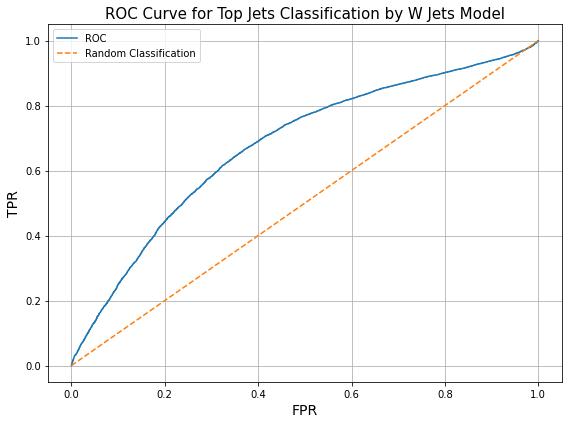

In [ ]:
# Running the function to import the images, setting top jets as the signal
X_train, X_test, y_train, y_test, X_S, X_BG = import_data(inputs, 'top')

############################################################################# Accuracy

# Evaluating the model's accuracy against all testing images/labels
print("The model's accuracy over all testing images is:")
model.evaluate(X_test,y_test)

# Evaluating the model's accuracy against each .npz files images/labels
print("With accuracies on each individual image set, increasing in energy range, of:")
for i in inputs:
  X_tr, X_te, y_tr, y_te, X_S, X_BG = import_data([i], 'top')
  model.evaluate(X_te,y_te,batch_size=20)

############################################################################# F1 Score

# Making predictions of signal/background
yhat = model.predict(X_test, verbose=0)   # Two columns, prob of being SG and BG
classes_x=np.argmax(yhat,axis=1)          # Taking highest prob frome each column

# Calculating the precision, recall and F1 Score
print(f"The model's precision is {precision_score(y_test,classes_x)}, with a recall of {recall_score(y_test,classes_x)}.")
print(f"These combine to give the model an F1 Score of {f1_score(y_test,classes_x)}")

############################################################################# ROC AUC

# Obtaining the FPRs and TPRs
fpr, tpr, thresholds = roc_curve(y_test, yhat[:,1])

# Defining a figure, and plotting the ROC (with baseline)
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(fpr,tpr,label='ROC')
ax1.plot((0,1),(0,1),linestyle='--',label='Random Classification')

# Formatting the figure
ax1.set_title('ROC Curve for Top Jets Classification by W Jets Model', fontsize=15)
ax1.set_xlabel('FPR',fontsize=14)
ax1.set_ylabel('TPR',fontsize=14)
ax1.legend()
ax1.grid()
fig.tight_layout()

# Calculating the AUC
auc = roc_auc_score(y_test, yhat[:,1])
print(f"The area under the ROC curve for this model is {auc}.")
plt.savefig('ROC Curve Top.png',dpi=300, facecolor='w')

## Conclusion
As will be discussed further in the report, the results above show that reasonably successful image classification has been achieved by a convolutional neural network. The model was trained on W jet images, and achieved an F1 score of 0.79, with an AUROC of 0.83 when evaluated on more W jets. When used to evaluate top jets, the model produced weaker scores of 0.62 and 0.68 respectively, still displaying positive classification performance, only to a lesser extent.